<a href="https://colab.research.google.com/github/YutakaOsaki/ouenka-colab/blob/main/Preproccesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 音声処理＆可視化に必要なライブラリをインストール
!pip install -q librosa ffmpeg-python

# ffmpegが必要なMP3のデコードをサポート
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
from scipy.ndimage import maximum_filter, uniform_filter
from scipy.signal import convolve2d
from scipy.ndimage import label, find_objects
import matplotlib.patches as patches
from skimage import measure
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import os
import random

In [ ]:
# --- augment関数群（いずれも引数：y, sr）---
def augment_pitch_shift(y, sr):
    steps = random.uniform(-3, 3)
    return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=steps)

def augment_white_noise(y, sr):
    wn = np.random.randn(len(y))
    return y + 0.005 * wn

# --- メイン処理 ---
def visualize_region_grid(
    audio_path,
    t_start,
    role,
    duration=10.0,
    fmin=2000,
    fmax=3500,
    kernel_size=(30, 15),
    region_threshold=1.0,
    min_region_size=(1, 1),
    n_fft=2048,
    hop_length=512,
    grid_shape=(30, 100)
):
    # --- 音声読み込み＆STFT ---
    y_full, sr = librosa.load(audio_path, sr=None)
    y = y_full[int(t_start*sr):int((t_start+duration)*sr)]
    y = y / (np.max(np.abs(y)) + 1e-9)

    if role == "train":
      # augment: 20% の確率で適用
      if random.random() < 0.2:
          aug_func = random.choice([augment_pitch_shift, augment_white_noise])
          y = aug_func(y, sr)

    # --- STFT処理 ---
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    mask = (freqs >= fmin) & (freqs <= fmax)
    S_db_band = S_db[mask, :]

    # --- ノーマライズ → 差分抽出 ---
    mu, sigma = S_db_band.mean(), S_db_band.std() + 1e-9
    S_norm = (S_db_band - mu) / sigma * np.sqrt(2.0)
    S_blur = convolve2d(S_norm, np.ones(kernel_size)/np.prod(kernel_size), mode="same", boundary="symm")
    S_diff = S_norm - S_blur
    binary = (S_diff > region_threshold).astype(np.uint8)

    # --- ラベリング＆サイズフィルタリング ---
    labeled = measure.label(binary)
    props = measure.regionprops(labeled)
    valid = [p.label for p in props
             if (p.bbox[2]-p.bbox[0]) >= min_region_size[0]
             and (p.bbox[3]-p.bbox[1]) >= min_region_size[1]]
    filtered = np.isin(labeled, valid).astype(np.uint8)

    # --- グリッドへの変換 ---
    rows, cols = grid_shape
    h, w = filtered.shape
    block_h = h / rows
    block_w = w / cols
    grid = np.zeros((rows, cols), dtype=np.uint8)
    for i in range(rows):
        for j in range(cols):
            y0, y1 = int(i*block_h), int((i+1)*block_h)
            x0, x1 = int(j*block_w), int((j+1)*block_w)
            if filtered[y0:y1, x0:x1].any():
                grid[i, j] = 1
    return grid



def anchor_fingerprint(grid: np.ndarray, anchor: tuple) -> np.ndarray:

    i0, j0 = anchor
    ref_val = grid[i0, j0]
    rows, cols = grid.shape
    codes = (ref_val << 1) | grid
    fingerprint = np.delete(codes.ravel(), i0 * cols + j0).astype(np.uint8)
    return fingerprint


def anchor_fingerprint_all(grid: np.ndarray) -> np.ndarray:
    rows, cols = grid.shape
    n_feat = rows * cols - 1

    # 決め打ちでアンカーを指定（合計10個）
    anchors = [
        (5, 10),
        (5, 45),
        (5, 90),

        (15, 10),
        (15, 45),
        (15, 90),

        (25, 10),
        (25, 45),
        (25, 90),
    ]

    result = []
    for anchor in anchors:
        fp = anchor_fingerprint(grid, anchor)
        result.append(fp.astype(np.float32))

    return np.concatenate(result).reshape(1, -1)

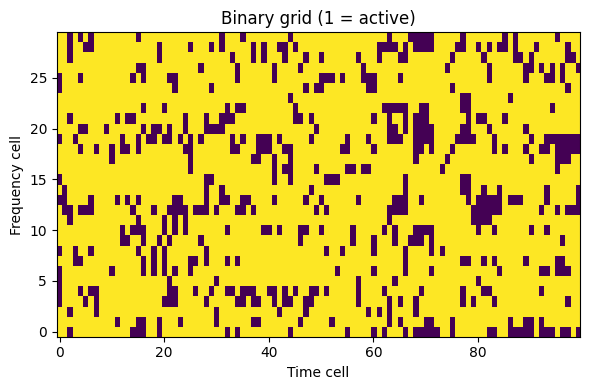

In [ ]:
grids = visualize_region_grid("/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/santana-playing-4.mp3", t_start=5, role="train")
plt.figure(figsize=(6, 4))          # サイズはお好みで
plt.imshow(grids, aspect="auto", origin="lower")  # 0/1 をそのまま描画
plt.title("Binary grid (1 = active)")
plt.xlabel("Time cell")
plt.ylabel("Frequency cell")
plt.tight_layout()
plt.show()

In [4]:
# --- 音声ファイル情報 ---
audio_files = {
    "nishikawa": [
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/nishikawa-playing-1.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/nishikawa-playing-2.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/nishikawa-playing-3.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/nishikawa-playing-4.mp3",
        ],
    "commontheme": [
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/commontheme-playing-1.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/commontheme-playing-2.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/commontheme-playing-3.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/commontheme-playing-4.mp3",
        ],
    "chance5": [
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/chance5-playing-1.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/chance5-playing-2.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/chance5-playing-3.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/chance5-playing-4.mp3",
        ],
    "ozuna": [
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/ozuna-playing-1.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/ozuna-playing-2.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/ozuna-playing-3.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/ozuna-playing-4.mp3",
        ],
    "santana": [
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/santana-playing-1.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/santana-playing-2.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/santana-playing-3.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/santana-playing-4.mp3",
        ],
    "yamada": [
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/yamada-playing-1.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/yamada-playing-2.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/yamada-playing-3.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/yamada-playing-4.mp3",
    ],
    "murakami": [
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/murakami-playing-1.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/murakami-playing-2.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/murakami-playing-3.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/murakami-playing-4.mp3",
    ],
    "aoki": [
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/aoki-playing-1.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/aoki-playing-2.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/aoki-playing-3.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/aoki-playing-4.mp3",
    ],
    "namiki": [
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/namiki-playing-1.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/namiki-playing-2.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/namiki-playing-3.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/namiki-playing-4.mp3",
        ],
    "akahane": [
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/akahane-playing-1.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/akahane-playing-2.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/akahane-playing-3.mp3",
        "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/akahane-playing-4.mp3",
        ],
}

In [ ]:
import os
import datetime
from keras.utils import to_categorical

def save_dataset_as_npz_label(X, label, all_labels, output_dir, samples_per_label):
    """ラベル単位で npz を即保存"""
    timestamp   = datetime.datetime.now().strftime("%Y%m")
    filename    = f"dataset_{label}_{timestamp}9_{samples_per_label}.npz"
    output_path = os.path.join(output_dir, filename)

    y_indices     = np.full(len(X), all_labels.index(label), dtype=np.int32)
    y_categorical = to_categorical(y_indices, num_classes=len(all_labels))

    np.savez_compressed(
        output_path,
        X=X.astype(np.float32),
        y_label=np.array([label]),
        y_indices=y_indices,
        y_categorical=y_categorical
    )
    print(f"✅ saved: {output_path}")

# ---------- メイン ----------
output_dir  = "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250709-3x10"
samples_per_label = 2000
all_labels = sorted(audio_files.keys())       # ← 先に全ラベル一覧を確定

for label, paths in audio_files.items():
    fp_list = []                              # ← ラベル専用バッファ

    total_files    = len(paths)
    crops_per_file = samples_per_label // total_files

    for path in paths:
        try:
            y_full, sr      = librosa.load(path, sr=None)
            total_duration  = librosa.get_duration(y=y_full, sr=sr)
            max_start       = max(0, total_duration - 10.0)
            np.random.seed(0)
            t_starts        = np.random.uniform(0, max_start, crops_per_file)

            for t in tqdm(t_starts, desc=f"Processing {label} ({os.path.basename(path)})"):
                grid = visualize_region_grid(path, t_start=t, role="train")
                fp   = anchor_fingerprint_all(grid)
                fp_list.append(fp[0])

        except Exception as e:
            print(f"❌ 読み込み失敗: {path} → {e}")

    # ---------- ラベル分すべて集まったら即保存 ----------
    save_dataset_as_npz_label(
        X                 = np.array(fp_list),
        label             = label,
        all_labels        = all_labels,
        output_dir        = output_dir,
        samples_per_label = samples_per_label
    )


Processing aoki (aoki-playing-4.mp3): 100%|██████████| 500/500 [01:56<00:00,  4.29it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250709-3x10/dataset_aoki_2025079_2000.npz


Processing namiki (namiki-playing-4.mp3): 100%|██████████| 500/500 [02:06<00:00,  3.96it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250709-3x10/dataset_namiki_2025079_2000.npz


Processing akahane (akahane-playing-4.mp3): 100%|██████████| 500/500 [01:53<00:00,  4.39it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250709-3x10/dataset_akahane_2025079_2000.npz


# method f[Hz]のangleをgridsで格納

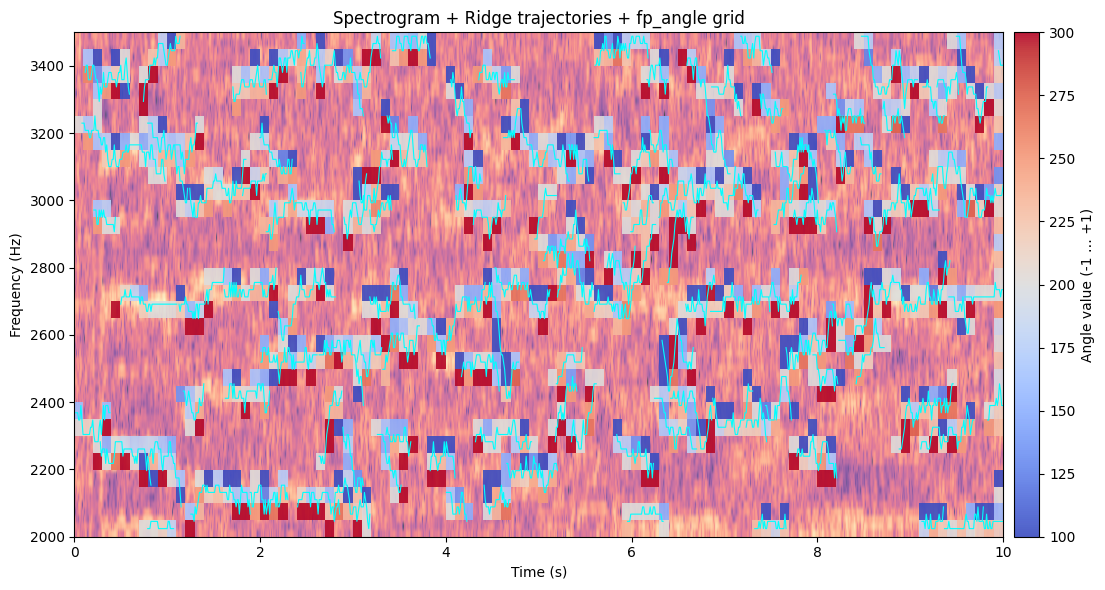

In [62]:
import numpy as np, librosa, matplotlib.pyplot as plt
from scipy.signal import convolve2d

# ------ノイズ・ピッチ・タイムストレッチ関数 ------------------------------------

def add_white_noise(y, noise_level=0.01):
    noise = np.random.randn(len(y))
    return y + noise_level * noise

def random_pitch_shift(y, sr, max_steps=1.5):
    steps = np.random.uniform(-max_steps, max_steps)
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

def random_crop_and_stretch(y, sr, duration=10.0, crop_range=(9.0, 11.0)):
    crop_dur = np.random.uniform(*crop_range)
    crop_len = int(crop_dur * sr)
    if len(y) > crop_len:
        start = np.random.randint(0, len(y) - crop_len)
        y_crop = y[start:start+crop_len]
    else:
        y_crop = y
    # resample で stretch 相当を実装
    current_sr = sr * (len(y_crop) / (duration * sr))
    y_stretched = librosa.resample(y_crop, orig_sr=current_sr, target_sr=sr)
    return y_stretched


# ---------- リッジ抽出は同じ ----------------------------------
def extract_ridges(S_diff, ridge_tol=2, min_len=20):
    peak_mask = librosa.util.localmax(S_diff) & (S_diff > 0)
    peaks = np.argwhere(peak_mask);  peaks = peaks[np.argsort(peaks[:, 1])]
    ridges, active = [], []
    for bin_, frame in peaks:
        attached = False
        for tr in active:
            last_f, last_bin, pts = tr
            if frame == last_f + 1 and abs(bin_-last_bin) <= ridge_tol:
                tr[0], tr[1] = frame, bin_;  pts.append((frame, bin_));  attached = True; break
        if not attached:  active.append([frame, bin_, [(frame, bin_)]])
        for tr in active[:]:
            if frame > tr[0] + 1:
                if len(tr[2]) >= min_len: ridges.append(tr[2])
                active.remove(tr)
    for tr in active:
        if len(tr[2]) >= min_len: ridges.append(tr[2])
    return ridges

# ---------- 角度グリッド (Δf と Δt を両方考慮) ----------------
def compute_angle_grid(freqs, ridges, duration, fmin, fmax,
                       grid_shape=(30, 100), hop_length=512, sr=22050,
                       use_sigmoid=True):
    rows, cols = grid_shape
    sum_angle, hits = np.zeros((rows, cols), np.float32), np.zeros((rows, cols), np.int32)

    cell_hz   = (fmax - fmin) / rows          # 1 行の高さ (Hz)
    cell_sec  =  duration / cols              # 1 列の幅   (s)

    for pts in ridges:
        t = np.array([p[0]*hop_length/sr for p in pts])
        f = np.array([freqs[p[1]] for p in pts])

        col = np.clip((t / duration * cols).astype(int), 0, cols-1)
        row = np.clip(((f - fmin)/(fmax-fmin) * rows).astype(int), 0, rows-1)

        for k in range(len(col)-1):
            c, r  = col[k], row[k]
            dt, df = t[k+1]-t[k], f[k+1]-f[k]
            if dt == 0: continue
            x  = (df / cell_hz) / (dt / cell_sec)   # 傾きをセル基準で正規化

            val = int((2/(1+np.exp(-3*x))-1)*100)+200 if use_sigmoid else np.clip(x, -1, 1)
            sum_angle[r, c] += val;  hits[r, c] += 1

    fp_angle = np.divide(sum_angle, hits, where=hits>0)
    fp_angle[hits==0] = 0.0                      # ヒット無しセルは 0
    return fp_angle

# ===============================================================
# ① 角度グリッド計算＋リッジ取得をまとめて返す
# ===============================================================
def compute_fp_and_ridges(audio_path,
                          t_start=0.0, duration=10.0,
                          fmin=2000, fmax=3500,
                          grid_shape=(30, 100),
                          n_fft=2048, hop_length=512,
                          ridge_tol=2, min_len=20,
                          use_sigmoid=True,
                          aug_prob=0.2):

    # ------- 音声ロード
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    y = y[int(t_start*sr): int((t_start+duration+1.0)*sr)] # crop 11s: duration 10 + 1

    # ------- augmentation
    if np.random.rand() < 0.4:
        y = random_crop_and_stretch(y, sr, duration=duration, crop_range=(9.0, 11.0))
    elif np.random.rand() > 0.9:
        y = random_crop_and_stretch(y, sr, duration=duration, crop_range=(9.0, 11.0))
    if np.random.rand() > 0.60:
        y = add_white_noise(y)
    if np.random.rand() < 0.70:
      if np.random.rand() > 0.30:
          y = random_pitch_shift(y, sr)
    if np.random.rand() < 0.4:
        y = random_crop_and_stretch(y, sr, duration=duration, crop_range=(9.0, 11.0))
    elif np.random.rand() > 0.9:
        y = random_crop_and_stretch(y, sr, duration=duration, crop_range=(9.0, 11.0))


    # # ------- augmentation 20%の確率で適用
    # if np.random.rand() < aug_prob:
    #     y = random_crop_and_stretch(y, sr, duration=duration, crop_range=(9.0, 11.0))
    # if np.random.rand() < aug_prob:
    #     y = add_white_noise(y, noise_level=noise_level)
    # if np.random.rand() < aug_prob:
    #     y = random_pitch_shift(y, sr, max_steps=max_pitch_steps)
    # if np.random.rand() < aug_prob:
    #     y = random_crop_and_stretch(y, sr, duration=duration, crop_range=(9.0, 11.0))

    # ------- STFT
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # ------- 帯域抽出 & S_diff
    mask = (freqs >= fmin) & (freqs <= fmax)
    S_band = S_db[mask]
    S_norm = (S_band - S_band.mean()) / (S_band.std()+1e-9) * np.sqrt(2)
    S_blur = convolve2d(S_norm, np.ones((30,15))/450, mode="same", boundary="symm")
    S_diff = S_norm - S_blur

    # ------- リッジ抽出
    ridges = extract_ridges(S_diff, ridge_tol, min_len)

    # ------- fp_angle 行列
    fp_angle = compute_angle_grid(
        freqs[mask], ridges,
        duration, fmin, fmax,
        grid_shape, hop_length, sr,
        use_sigmoid
    )

    return fp_angle.astype(np.float32, copy=False), ridges, S_diff, freqs[mask], sr

# ===============================================================
# ② 可視化 ：スペクトログラム + リッジ + fp_angle グリッド
# ===============================================================
def visualize_fp_with_ridges(fp_angle, ridges, S_diff, freqs_band,
                             duration, fmin, fmax,
                             grid_shape=(30,100),
                             hop_length=512, sr=22050,
                             alpha_spec=0.5, alpha_grid=0.9,
                             cmap_grid="coolwarm"):

    rows, cols = grid_shape
    extent = [0, duration, fmin, fmax]

    fig, ax = plt.subplots(figsize=(12,6))

    # 1) 背景スペクトログラム
    ax.imshow(S_diff, origin="lower", aspect="auto",
              cmap="magma", extent=extent, alpha=alpha_spec)

    # 2) リッジ軌跡
    for pts in ridges:
        xs = [p[0] * hop_length / sr for p in pts]
        ys = [freqs_band[p[1]] for p in pts]
        ax.plot(xs, ys, color="cyan", linewidth=0.8)

    # 3) fp_angle グリッド
    masked = np.ma.masked_equal(fp_angle, 0)   # ← 0 をマスク

    im = ax.imshow(masked, origin="lower", aspect="auto",
                  cmap=cmap_grid, extent=extent,
                  interpolation="nearest",
                  vmin=100, vmax=300,            # 100〜300 だけ着色
                  alpha=alpha_grid)

    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label("Angle value (-1 … +1)")

    ax.set_title("Spectrogram + Ridge trajectories + fp_angle grid")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# ------------------------- 使い方例 -------------------------
audio = "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/data/aoki-playing-4.mp3"
fp_angle, ridges, S_diff, freqs_band, sr = compute_fp_and_ridges(
    audio, t_start=10, duration=10.0, grid_shape=(30,100),
    use_sigmoid=True
)

visualize_fp_with_ridges(
    fp_angle, ridges, S_diff, freqs_band,
    duration=10.0, fmin=2000, fmax=3500,
    grid_shape=(30,100), hop_length=512, sr=sr,
    alpha_spec=0.7, alpha_grid=0.9
)

# preprocessing fp angle

In [63]:
import numpy as np
import librosa
from scipy.signal import convolve2d

def compute_fp_and_ridges(audio_path,
                          t_start=0.0, duration=10.0,
                          fmin=2000, fmax=3500,
                          grid_shape=(30, 100),
                          n_fft=2048, hop_length=512,
                          ridge_tol=2, min_len=20,
                          use_sigmoid=True):
    """リッジ列抽出と角度グリッド計算を 1 本の関数で行う"""
    # --------------------------------------------------
    # 1. 音声ロード & STFT
    # --------------------------------------------------
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    #y = y[int(t_start * sr): int((t_start + duration) * sr)]

    # --------------------------------------------------
    # 2. Augmentation
    # --------------------------------------------------
    if np.random.rand() < 0.2:
      if np.random.rand() < 0.3:
          y = y[int(t_start * sr): int((t_start + duration+1) * sr)]
          y = random_crop_and_stretch(y, sr, duration=duration, crop_range=(9.0, 11.0))
      elif np.random.rand() > 0.9:
          y = y[int(t_start * sr): int((t_start + duration+1) * sr)]
          y = random_crop_and_stretch(y, sr, duration=duration, crop_range=(9.0, 11.0))
      else:
          y = y[int(t_start * sr): int((t_start + duration) * sr)]
      if np.random.rand() > 0.60:
          y = add_white_noise(y)
      if np.random.rand() < 0.70:
        if np.random.rand() > 0.30:
            y = random_pitch_shift(y, sr)
    else:
      y = y[int(t_start * sr): int((t_start + duration) * sr)]

    # --------------------------------------------------
    # 3. STFT
    # --------------------------------------------------
    S     = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db  = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # --------------------------------------------------
    # 4. 指定帯域のスペクトログラム差分
    # --------------------------------------------------
    mask   = (freqs >= fmin) & (freqs <= fmax)
    S_band = S_db[mask]                                # (bins × frames)
    S_norm = (S_band - S_band.mean()) / (S_band.std() + 1e-9) * np.sqrt(2)
    S_blur = convolve2d(S_norm, np.ones((30, 15)) / 450, mode="same", boundary="symm")
    S_diff = S_norm - S_blur

    # --------------------------------------------------
    # 5. リッジ抽出
    # --------------------------------------------------
    peak_mask = librosa.util.localmax(S_diff) & (S_diff > 0)
    peaks     = np.argwhere(peak_mask)
    peaks     = peaks[np.argsort(peaks[:, 1])]          # frame 順

    ridges, active = [], []                             # active: [last_frame, last_bin, pts]
    for bin_, frame in peaks:
        attached = False
        for tr in active:
            last_f, last_bin, pts = tr
            if frame == last_f + 1 and abs(bin_ - last_bin) <= ridge_tol:
                tr[0], tr[1] = frame, bin_
                pts.append((frame, bin_))
                attached = True
                break
        if not attached:
            active.append([frame, bin_, [(frame, bin_)]])
        # 1 フレーム以上空いた軌跡を確定
        for tr in active[:]:
            if frame > tr[0] + 1:
                if len(tr[2]) >= min_len:
                    ridges.append(tr[2])
                active.remove(tr)
    # 終端処理
    for tr in active:
        if len(tr[2]) >= min_len:
            ridges.append(tr[2])

    # --------------------------------------------------
    # 6. 角度グリッド計算（インライン化部分）
    # --------------------------------------------------
    rows, cols = grid_shape
    sum_angle = np.zeros((rows, cols), np.float32)
    hits      = np.zeros((rows, cols), np.int32)

    cell_hz  = (fmax - fmin) / rows
    cell_sec = duration / cols

    freq_band = freqs[mask]

    for pts in ridges:
        # 時間 (s) と周波数 (Hz) へ変換
        t = np.array([p[0] * hop_length / sr for p in pts])
        f = np.array([freq_band[p[1]] for p in pts])

        # グリッド座標
        col = np.clip((t / duration * cols).astype(int),                0, cols - 1)
        row = np.clip(((f - fmin) / (fmax - fmin) * rows).astype(int),  0, rows - 1)

        # セル単位の角度を集計
        for k in range(len(col) - 1):
            c, r  = col[k], row[k]
            dt, df = t[k + 1] - t[k], f[k + 1] - f[k]
            if dt == 0:
                continue
            x = (df / cell_hz) / (dt / cell_sec)

            val = (2 / (1 + np.exp(-1.2 * x)) - 1) * 100 + 200
            sum_angle[r, c] += int(val)
            hits[r, c]      += 1

    fp_angle = np.divide(sum_angle, hits, where=hits > 0)
    fp_angle[hits == 0] = 0.0

    # --------------------------------------------------
    # 7. 出力
    # --------------------------------------------------
    return fp_angle.astype(np.float32, copy=False), ridges, S_diff, freq_band, sr

In [66]:
import os
import datetime
from keras.utils import to_categorical

def save_dataset_as_npz_label(X, label, all_labels, output_dir, samples_per_label):
    """ラベル単位で npz を即保存"""
    timestamp   = datetime.datetime.now().strftime("%Y%m%d")
    filename    = f"dataset_{label}_{timestamp}_{samples_per_label}_noise.npz"
    output_path = os.path.join(output_dir, filename)

    y_indices     = np.full(len(X), all_labels.index(label), dtype=np.int32)
    y_categorical = to_categorical(y_indices, num_classes=len(all_labels))

    np.savez_compressed(
        output_path,
        X=X.astype(np.float32),
        y_label=np.array([label]),
        y_indices=y_indices,
        y_categorical=y_categorical
    )
    print(f"✅ saved: {output_path}")


# ---------- メイン ----------
output_dir        = "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle-noise"
samples_per_label = 400
all_labels        = sorted(audio_files.keys())

for label, paths in audio_files.items():
    fp_list = []

    total_files    = len(paths)
    crops_per_file = samples_per_label // total_files

    for path in paths:
        try:
            y_full, sr      = librosa.load(path, sr=None)
            total_duration  = librosa.get_duration(y=y_full, sr=sr)
            max_start       = max(0, total_duration - 10.0)

            np.random.seed(0)
            t_starts        = np.random.uniform(0, max_start, crops_per_file)

            for t in tqdm(t_starts, desc=f"Processing {label} ({os.path.basename(path)})"):
                # ---- fp_angle を直接取得 ----
                fp_angle, _, _, _, _ = compute_fp_and_ridges(
                    audio_path = path,
                    t_start    = float(t),     # 必ず float で渡す
                    duration   = 10.0,
                    fmin       = 2000,
                    fmax       = 3500,
                    grid_shape = (30, 100),
                    hop_length = 512,
                    use_sigmoid= True
                )
                # そのまま 2D 行列で保存する場合
                fp_list.append(fp_angle.astype(np.float32))
                # もし 1 次元ベクトル化したい場合は ↓ に変更
                # fp_list.append(fp_angle.astype(np.float32).flatten())

        except Exception as e:
            print(f"❌ 読み込み失敗: {path} → {e}")

    # ---------- ラベル分が集まったら即保存 ----------
    save_dataset_as_npz_label(
        X                 = np.stack(fp_list),   # サンプル数 × 30 × 100
        label             = label,
        all_labels        = all_labels,
        output_dir        = output_dir,
        samples_per_label = samples_per_label
    )

Processing nishikawa (nishikawa-playing-4.mp3): 100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle-noise/dataset_nishikawa_20250712_400_noise.npz


Processing commontheme (commontheme-playing-1.mp3): 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
Processing commontheme (commontheme-playing-2.mp3): 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]
Processing commontheme (commontheme-playing-3.mp3): 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]
Processing commontheme (commontheme-playing-4.mp3): 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle-noise/dataset_commontheme_20250712_400_noise.npz


Processing chance5 (chance5-playing-4.mp3): 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle-noise/dataset_chance5_20250712_400_noise.npz


Processing ozuna (ozuna-playing-4.mp3): 100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle-noise/dataset_ozuna_20250712_400_noise.npz


Processing santana (santana-playing-4.mp3): 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle-noise/dataset_santana_20250712_400_noise.npz


Processing yamada (yamada-playing-4.mp3): 100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle-noise/dataset_yamada_20250712_400_noise.npz


Processing murakami (murakami-playing-4.mp3): 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle-noise/dataset_murakami_20250712_400_noise.npz


Processing aoki (aoki-playing-4.mp3): 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle-noise/dataset_aoki_20250712_400_noise.npz


Processing namiki (namiki-playing-4.mp3): 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle-noise/dataset_namiki_20250712_400_noise.npz


Processing akahane (akahane-playing-4.mp3): 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


✅ saved: /content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle-noise/dataset_akahane_20250712_400_noise.npz
